In [1]:
# --- STEP 1: DATA COLLECTION ---
# We are installing a library to scrape the Google Play Store
!pip install google-play-scraper pandas

import pandas as pd
from google_play_scraper import reviews, Sort

# 1. Define the Apps we want to analyze (Power BI vs Tableau)
apps = [
    {'name': 'Power BI', 'id': 'com.microsoft.powerbim'},
    {'name': 'Tableau', 'id': 'com.tableau.tableau_mobile'}
]

all_reviews = []

print("🚀 Starting Data Extraction... this may take a minute.")

# 2. Loop through both apps and scrape 2,000 most relevant reviews each
for app in apps:
    print(f"Scraping reviews for {app['name']}...")
    result, _ = reviews(
        app['id'],
        lang='en',           # English reviews
        country='us',        # US Market
        sort=Sort.MOST_RELEVANT, # Best quality reviews
        count=2000           # Number of reviews per app
    )

    # Label the data so we know which app it belongs to
    for review in result:
        review['app_name'] = app['name']
        all_reviews.append(review)

# 3. Convert to a DataFrame (Table)
df = pd.DataFrame(all_reviews)

# 4. Save to CSV
df.to_csv('bi_tools_reviews.csv', index=False)

print(f"✅ Success! Scraped {len(df)} total reviews.")
print("The file 'bi_tools_reviews.csv' is saved in your files panel.")
print(df[['app_name', 'content', 'score']].head())

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.6 MB/s eta 0:00:00
🚀 Starting Data Extraction... this may take a minute.
Scraping reviews for Power BI...
Scraping reviews for Tableau...
✅ Success! Scraped 2000 total reviews.
The file 'bi_tools_reviews.csv' is saved in your files panel.
   app_name                                            content  score
0  Power BI  Not fit for purpose. So small and fiddly that ...      1
1  Power BI  nothing needed to add. i would like the interf...      5
2  Power BI               very useful and easy to find reports      5
3  Power BI  fantastic application it gives all data in one...      5
4  Power BI  That's not mobile at all. First of all, there ...      1


In [2]:
# --- STEP 2: DATA CLEANING & PREPROCESSING ---
import re
import pandas as pd

# 1. Load the raw data we saved in Step 1
try:
    df = pd.read_csv('bi_tools_reviews.csv')
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: 'bi_tools_reviews.csv' not found. Please run Step 1 first.")

# 2. Text Cleaning Function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove emojis and special characters (keep only words and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("🧹 Cleaning text data...")
df['clean_content'] = df['content'].apply(clean_text)

# 3. Filter out useless short reviews (length < 4 words)
# Insights come from detailed reviews, not one-word answers.
df = df[df['clean_content'].str.split().str.len() > 4]

# 4. Fix Date Format
# Google Play Scraper returns 'at' as a datetime, but CSV saves it as string.
# We explicitly convert it back to datetime.
df['at'] = pd.to_datetime(df['at'])

# 5. Save the Cleaned Data
df.to_csv('cleaned_bi_reviews.csv', index=False)

print(f"✅ Cleaning Complete! {len(df)} high-quality reviews remaining.")
print("Preview of clean data:")
print(df[['app_name', 'at', 'clean_content']].head())

Data loaded successfully!
🧹 Cleaning text data...
✅ Cleaning Complete! 1817 high-quality reviews remaining.
Preview of clean data:
   app_name                  at  \
0  Power BI 2025-11-05 00:33:25   
1  Power BI 2025-10-26 14:46:53   
2  Power BI 2025-12-04 13:01:24   
3  Power BI 2025-10-27 12:28:27   
4  Power BI 2020-07-10 09:52:42   

                                       clean_content  
0  not fit for purpose so small and fiddly that y...  
1  nothing needed to add i would like the interfa...  
2               very useful and easy to find reports  
3  fantastic application it gives all data in one...  
4  thats not mobile at all first of all there is ...  


In [3]:
# --- STEP 3: ASPECT MINING & SENTIMENT ANALYSIS ---
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# 1. Download VADER lexicon (the dictionary of sentiment words)
nltk.download('vader_lexicon')
sent = SentimentIntensityAnalyzer()

# 2. Define our "Business Aspects"
# We look for these keywords to understand what the user is talking about.
aspect_keywords = {
    "Performance": ['slow', 'lag', 'crash', 'freeze', 'bug', 'fast', 'speed', 'responsive', 'loading'],
    "UI/UX": ['interface', 'design', 'color', 'menu', 'button', 'screen', 'look', 'navigat', 'font'],
    "Login/Access": ['login', 'sign in', 'password', 'mfa', 'authenticat', 'connect', 'server', 'credentials'],
    "Features": ['filter', 'drill', 'export', 'pdf', 'map', 'sort', 'calculation', 'date']
}

# 3. Function to detect Aspect
def detect_aspect(text):
    found_aspects = []
    for aspect, keywords in aspect_keywords.items():
        for word in keywords:
            if word in text:
                found_aspects.append(aspect)
                break # Stop checking this aspect if we found a keyword
    return found_aspects if found_aspects else ['General'] # Default to 'General' if no keywords found

# 4. Apply Aspect Detection
print("🕵️‍♂️ Categorizing reviews into aspects...")
df['aspects'] = df['clean_content'].apply(detect_aspect)

# 5. Explode the list (If a review mentions 2 aspects, we split it into 2 rows for better analysis)
df_exploded = df.explode('aspects')

# 6. Apply Sentiment Scoring (VADER)
# Compound score ranges from -1 (Most Negative) to +1 (Most Positive)
print("❤️ calculating sentiment scores...")
df_exploded['sentiment_score'] = df_exploded['clean_content'].apply(lambda x: sent.polarity_scores(x)['compound'])

# 7. Classify Sentiment (Positive, Neutral, Negative)
def categorize_sentiment(score):
    if score > 0.05: return 'Positive'
    if score < -0.05: return 'Negative'
    return 'Neutral'

df_exploded['sentiment_label'] = df_exploded['sentiment_score'].apply(categorize_sentiment)

# 8. Save Final Data for Visualization
df_exploded.to_csv('final_bi_analysis.csv', index=False)

print("✅ Analysis Complete!")
print("Here is a sneak peek of the Intelligence you created:")
print(df_exploded[['app_name', 'aspects', 'sentiment_label', 'sentiment_score']].head(10))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


🕵️‍♂️ Categorizing reviews into aspects...
❤️ calculating sentiment scores...
✅ Analysis Complete!
Here is a sneak peek of the Intelligence you created:
   app_name      aspects sentiment_label  sentiment_score
0  Power BI  Performance        Positive           0.2011
1  Power BI        UI/UX        Positive           0.6151
2  Power BI      General        Positive           0.7474
3  Power BI  Performance        Positive           0.8271
4  Power BI  Performance        Negative          -0.7819
4  Power BI        UI/UX        Negative          -0.7819
5  Power BI      General        Positive           0.4767
6  Power BI      General        Positive           0.6369
7  Power BI      General        Positive           0.7496
8  Power BI      General        Positive           0.4033


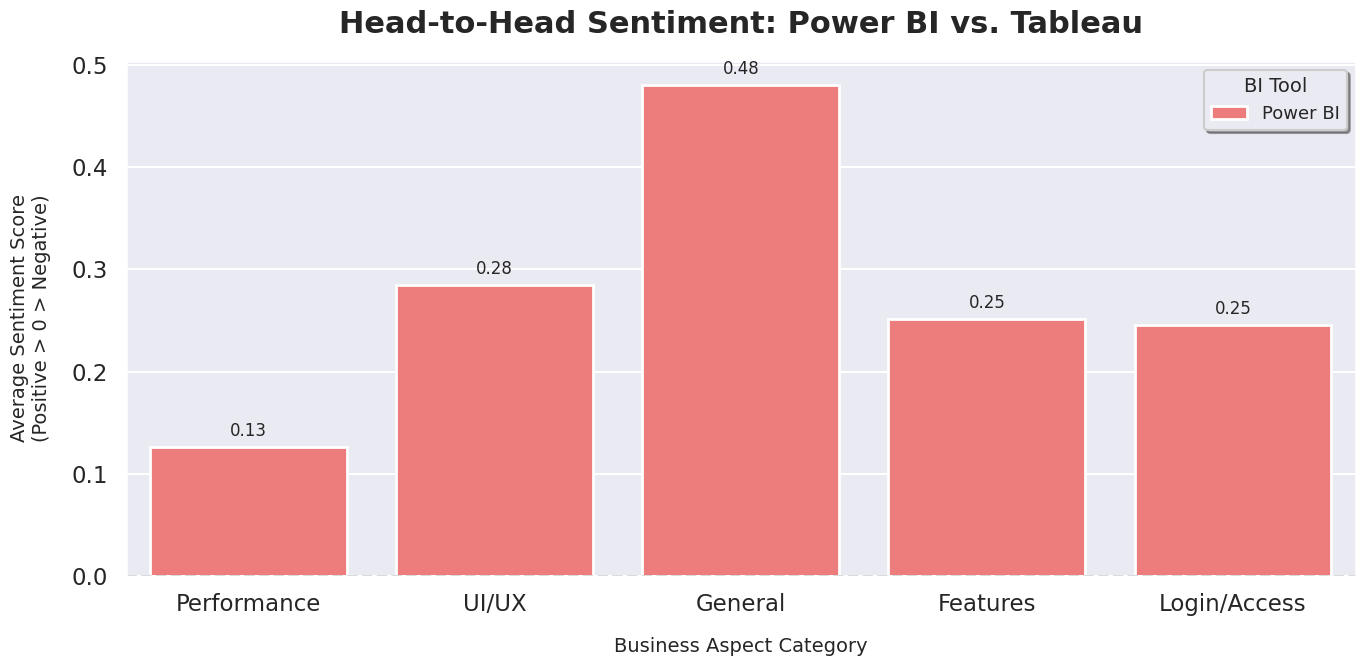

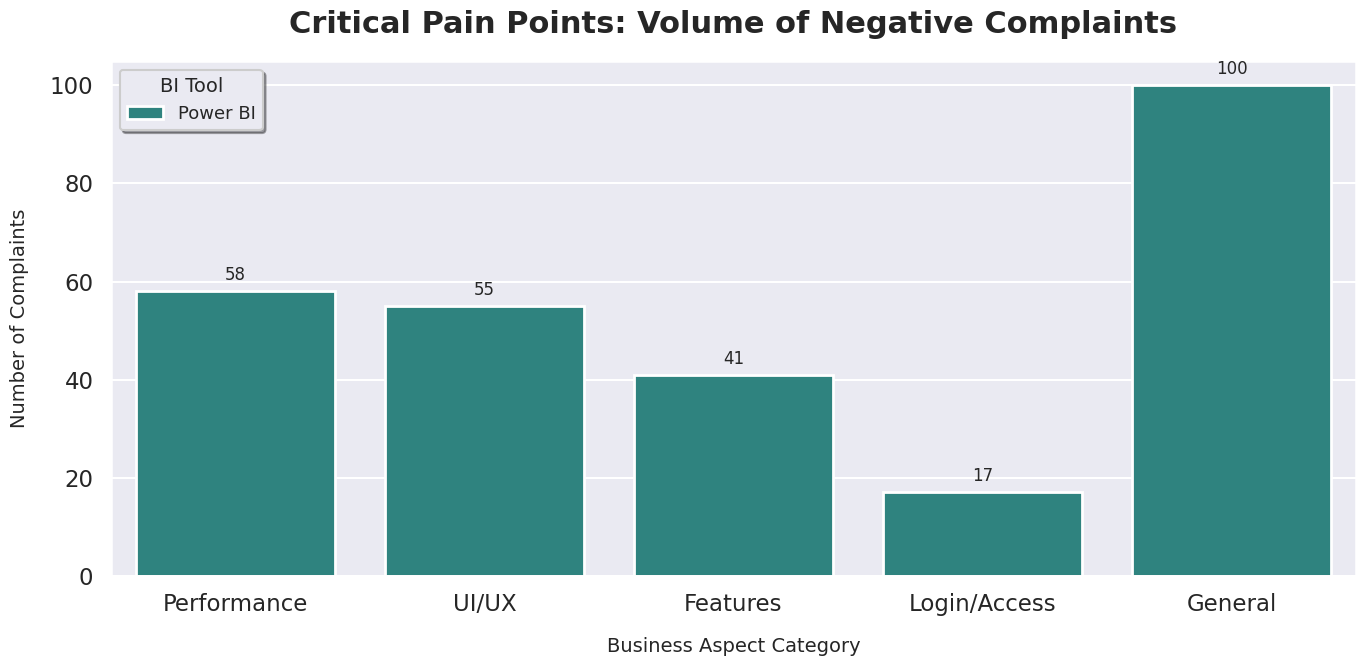

In [5]:
# --- STEP 4 (REVISED - BEAUTIFUL VERSION) ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the data (just to be safe)
try:
    df = pd.read_csv('final_bi_analysis.csv')
except FileNotFoundError:
    print("⚠️ Error: Please make sure 'final_bi_analysis.csv' exists by running Step 3.")

# --- AESTHETIC SETUP ---
# 1. Set the theme to "darkgrid" for better contrast and "talk" context for bigger fonts
sns.set_theme(style="darkgrid", context="talk")

# 2. Define vibrant, distinct colors
# Using Coral Red for Power BI and bright Turquoise for Tableau
beauty_palette = {'Power BI': '#FF6B6B', 'Tableau': '#4ECDC4'}

# --- CHART 1: SENTIMENT BATTLEFIELD ---
plt.figure(figsize=(14, 7)) # Make the chart wider

chart1 = sns.barplot(
    data=df,
    x='aspects',
    y='sentiment_score',
    hue='app_name',
    palette=beauty_palette,
    errorbar=None,
    edgecolor='white', # Adds a clean white border around bars
    linewidth=2        # Makes the border thicker
)

# Add aesthetics
plt.title('Head-to-Head Sentiment: Power BI vs. Tableau', fontsize=22, fontweight='bold', pad=20)
plt.ylabel('Average Sentiment Score\n(Positive > 0 > Negative)', fontsize=14, labelpad=15)
plt.xlabel('Business Aspect Category', fontsize=14, labelpad=15)
plt.axhline(0, color='#333333', linewidth=2, linestyle='--') # Stronger zero line

# Add the exact numbers on top of the bars
for container in chart1.containers:
    chart1.bar_label(container, fmt='%.2f', padding=5, fontsize=12)

# Improve legend
plt.legend(title='BI Tool', title_fontsize='14', fontsize='13', loc='upper right', frameon=True, shadow=True)
plt.tight_layout()
plt.show()


# --- CHART 2: PAIN POINT VOLUME ---
negative_reviews = df[df['sentiment_label'] == 'Negative']
plt.figure(figsize=(14, 7))

# For the second chart, let's use a pre-defined vibrant palette called "viridis"
# It looks very modern.
chart2 = sns.countplot(
    data=negative_reviews,
    x='aspects',
    hue='app_name',
    palette='viridis', # Using a built-in modern palette here
    edgecolor='white',
    linewidth=2
)

# Add aesthetics
plt.title('Critical Pain Points: Volume of Negative Complaints', fontsize=22, fontweight='bold', pad=20)
plt.ylabel('Number of Complaints', fontsize=14, labelpad=15)
plt.xlabel('Business Aspect Category', fontsize=14, labelpad=15)

# Add exact counts on top of bars
for container in chart2.containers:
    chart2.bar_label(container, fmt='%d', padding=5, fontsize=12)

plt.legend(title='BI Tool', title_fontsize='14', fontsize='13', frameon=True, shadow=True)
plt.tight_layout()
plt.show()